In [1]:
import os
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.optim import Adam
import torchvision.transforms as transforms
from torchinfo import summary
from IPython.display import Image, display, Video, clear_output
from matplotlib import pyplot as plt
import imageio
import logging
import moviepy.editor as moviepy

/home/joe/Projects/Machine Learning/General Projects/Images/LipNet/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f'You are currently using {"gpu" if device.type == "cuda" else device.type}')

You are currently using gpu


In [3]:
class GRID_Dataset(Dataset):
    def __init__(self, data_dir: str, dataset_type: str = 'train'):
        self.video_dir = os.path.join(data_dir, "videos", "s1")
        self.alignments_dir = os.path.join(data_dir, "alignments", "s1")
        self.letters = [token for token in " abcdefghijklmnopqrstuvwxyz"]
        self.frame_pad_length = self.get_max_frame_count(self.video_dir)
        self.token_pad_length = self.get_max_token_count(self.alignments_dir)
        
    def __len__(self):
        return len(os.listdir(self.video_dir))

    def __getitem__(self, idx):
        selected_item = os.listdir(self.video_dir)[idx].split('.mpg')[0]
        video_path = os.path.join(self.video_dir, f"{selected_item}.mpg")
        alignments_path = os.path.join(self.alignments_dir, f"{selected_item}.align")
        
        frames, frames_length = self.load_videos(video_path, self.frame_pad_length)
        tokens, tokens_lengths = self.load_alignments(alignments_path, self.token_pad_length, 0)
        return frames, frames_length, tokens, tokens_lengths, selected_item
    
    def get_max_frame_count(self, video_dir: str) -> int:
        max_frame_count = 0

        for path in os.listdir(video_dir):
            cap = cv2.VideoCapture(os.path.join(video_dir, path))
            current_frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            if current_frame_count > max_frame_count:
                max_frame_count = current_frame_count
        
        return max_frame_count
    
    def get_max_token_count(self, alignments_dir: str) -> int:
        max_token_count = 0

        for path in os.listdir(alignments_dir):
            current_token_count = 0
            
            with open(os.path.join(alignments_dir, path), 'r') as f:
                lines = f.readlines()

            for i, line in enumerate(lines):
                line = line.split()
                if line[-1] != "sil":
                    current_token_count += len(line[-1]) + 1
        
            if current_token_count > max_token_count:
                max_token_count = current_token_count
        
        return max_token_count
    
    def load_videos(self, path: str, pad_length: int) -> torch.tensor:
        cap = cv2.VideoCapture(path)
        frames = torch.tensor(())
        
        for i in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
            ret, frame = cap.read()
            frame = torch.from_numpy(frame)                                                        # [Height, Width, Channel]
            frame = frame.unsqueeze(0)                                                             # [Seq_Length, Height, Width, Channel]
            frame = frame.permute(0, -1, 1, 2)                                                     # [Seq_Length, Channel, Height, Width]
            frame = frame[:, :, 180:250, 100:220]                                                  # Extract just the mouth piece
            frame = transforms.Grayscale()(frame)
            frames = torch.cat((frames, frame), dim=0)
            
        frames = frames.type(torch.FloatTensor)                                                    # Cast to a float32
        
        mean = torch.mean(frames)
        std_dev = torch.std(frames)
        
        frames = (frames-mean) / std_dev                                                           # Normalize the frames
        frames_length = frames.shape[0]
        
        frame_padding = pad_length - frames_length
        if frame_padding:
            final_frame = frames[-1].unsqueeze(0)
            frames = torch.cat([frames, final_frame.repeat(frame_padding,1,1,1)], dim=0)           # Pad the frames with the final frame so all the videos have the same amount of frames
            
        return frames.permute(1, 0, 2, 3), frames_length                                           # [Batch, Channel, Seq_Length, Height, Width] <- This is done for Conv3D Layers
    
    def load_alignments(self, path: str, pad_length: int, pad_token: int) -> torch.tensor:
        with open(path, 'r') as f:
            lines = f.readlines()

        letter_tokens = []
        for i, line in enumerate(lines):                                                  # Loop through each line of the alignments file
            line = line.split()
            if line[-1] != "sil":                                                         # Only Tokenize the non-silent parts of the alignments file
                for letter in line[-1]:
                    letter_tokens.append(letter)                                          # Tokenize each letter of the word
                letter_tokens.append(' ')                                                 # Append a space token after each word
        
        letter_tokens = self.txt2arr(letter_tokens)                                       # Convert the string of characters into a list of tokens
        
        letter_token_lengths = torch.tensor(len(letter_tokens), dtype=torch.long)
        
        letter_tokens = letter_tokens + [pad_token]*(pad_length - len(letter_tokens))    # Pad the token list with given pad token so that all alignments are the same size
        return torch.tensor(letter_tokens), letter_token_lengths
    
    def txt2arr(self, txt, start=1):
        arr = []
        for character in txt:
            arr.append(self.letters.index(character) + start)
        return arr
    
    def arr2txt(self, arr, start=1):
        txt = []
        for number in arr:
            if (number >= start):
                txt.append(self.letters[number - start])
        return "".join(txt).strip()
    
    def ctc_decode(self, outputs, start=1):
        texts = []
        
        for idx in range(outputs.size(0)):
            start = 1
            pre = -1
            txt = []
            
            for n in outputs[idx]:
                if(pre != n and n >= start):                
                    if(len(txt) > 0 and txt[-1] == ' ' and self.letters[n - start] == ' '):
                        pass
                    else:
                        txt.append(self.letters[n - start])                
                pre = n
            
            texts.append(''.join(txt).strip())
        return texts

In [4]:
BATCH_SIZE = 6

training_dataset = GRID_Dataset(data_dir="data")
training_dataloader = DataLoader(training_dataset, batch_size=BATCH_SIZE, shuffle=True)

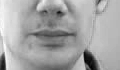

bin red by m eight please


In [5]:
batch = next(iter(training_dataloader))    # Index 0: Content - Videos                --- Shape - [Batch, Channel, Seq_Length, Height, Width], 
                                           # Index 1: Content - Videos Lengths        --- Shape - [Batch], 
                                           # Index 2: Content - Alignments            --- Shape - [Batch, Seq_Length], 
                                           # Index 3: Content - Alignments Lengths    --- Shape - [Batch]
                                           # Index 4: Content - Video Names           --- Shape - [Batch]

imageio.mimsave(os.path.join("display_data", "gif", "showcase_data.gif"), batch[0][0].permute(1, 2, 3, 0), fps=10)

clip = moviepy.VideoFileClip(os.path.join("data", "videos", "s1", f"{batch[4][0]}.mpg"))
clip.write_videofile(os.path.join("display_data", "mp4", "showcase_data.mp4"), fps=30)

clear_output(wait=True)

display(Video(os.path.join("display_data", "mp4", "showcase_data.mp4")))
display(Image(os.path.join("display_data", "gif", "showcase_data.gif")))

tokens = training_dataset.arr2txt(batch[2][0].tolist())
print(tokens)

In [6]:
class Permute(nn.Module):
    def __init__(self, *args: tuple):
        super(Permute, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.permute(self.shape)
    
class SelectItem(nn.Module):
    def __init__(self, item_index):
        super(SelectItem, self).__init__()
        self.item_index = item_index

    def forward(self, inputs):
        return inputs[self.item_index]

In [7]:
class LipNet(nn.Module):
    def __init__(self, vocab_size: int):
        super(LipNet, self).__init__()
        
        self.model = nn.Sequential()
        self.model.append(nn.Conv3d(in_channels=1, out_channels=128, kernel_size=3, padding='same'))
        self.model.append(nn.ReLU())
        self.model.append(nn.MaxPool3d((1,2,2)))

        self.model.append(nn.Conv3d(in_channels=128, out_channels=256, kernel_size=3, padding='same'))
        self.model.append(nn.ReLU())
        self.model.append(nn.MaxPool3d((1,2,2)))

        self.model.append(nn.Conv3d(in_channels=256, out_channels=75, kernel_size=3, padding='same'))
        self.model.append(nn.ReLU())
        self.model.append(nn.MaxPool3d((1,2,2)))

        self.model.append(Permute(0, 2, 1, 3, 4))
        self.model.append(nn.Flatten(2, -1))

        self.model.append(nn.LSTM(input_size=9000, hidden_size=256, num_layers=1, batch_first=True, bidirectional=True))
        self.model.append(SelectItem(0))
        self.model.append(nn.LSTM(input_size=512, hidden_size=256, num_layers=1, batch_first=True, bidirectional=True))
        self.model.append(SelectItem(0))
        
        self.model.append(nn.Linear(512, vocab_size))

    def forward(self, x):
        return self.model(x)

lipnet = LipNet(len(training_dataset.letters)+1)

In [8]:
summary(lipnet, input_size=(BATCH_SIZE, 1, 75, 70, 120), device="cpu")

Layer (type:depth-idx)                   Output Shape              Param #
LipNet                                   [6, 75, 28]               --
├─Sequential: 1-1                        [6, 75, 28]               --
│    └─Conv3d: 2-1                       [6, 128, 75, 70, 120]     3,584
│    └─ReLU: 2-2                         [6, 128, 75, 70, 120]     --
│    └─MaxPool3d: 2-3                    [6, 128, 75, 35, 60]      --
│    └─Conv3d: 2-4                       [6, 256, 75, 35, 60]      884,992
│    └─ReLU: 2-5                         [6, 256, 75, 35, 60]      --
│    └─MaxPool3d: 2-6                    [6, 256, 75, 17, 30]      --
│    └─Conv3d: 2-7                       [6, 75, 75, 17, 30]       518,475
│    └─ReLU: 2-8                         [6, 75, 75, 17, 30]       --
│    └─MaxPool3d: 2-9                    [6, 75, 75, 8, 15]        --
│    └─Permute: 2-10                     [6, 75, 75, 8, 15]        --
│    └─Flatten: 2-11                     [6, 75, 9000]             --
│ 

In [9]:
model_dir = "models"
log_dir = "logs"

optimizer = Adam(params=lipnet.parameters(), 
                 lr=0.00002,
                 amsgrad=True)
loss_fn = nn.CTCLoss()

logging.basicConfig(level=logging.INFO, format=' %(message)s ', handlers=[logging.FileHandler(os.path.join(log_dir, 'training-loss.txt'), mode='w'), logging.StreamHandler()])

 Epoch: 2000 -- Train Loss 0.009639873681589962 


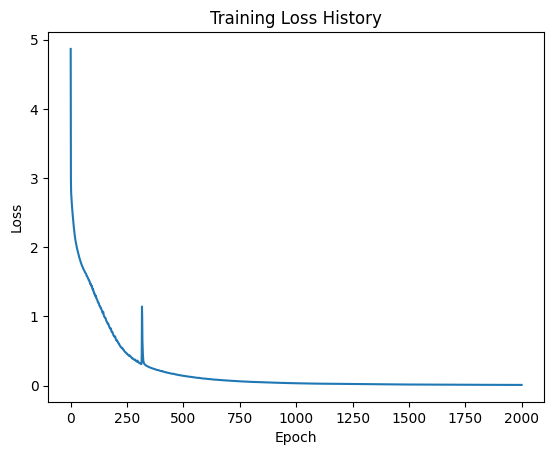

In [10]:
epochs = 1000
train_loss_history = []
lipnet = lipnet.to(device)
    
for epoch in range(1, epochs+1):
    train_loss = 0.0
    val_loss = 0.0

    lipnet.train()
    for videos, videos_length, alignments, alignments_lengths in training_dataloader:
        batch_size, channels, frames, hight, width = videos.shape
        batch_size, seq_length = alignments.shape
        
        videos = videos.to(device)
        alignments = alignments.to(device)
        
        optimizer.zero_grad()
        pred_alignments = lipnet(videos)                                          # [Batch, Seq Length, Class]
        pred_alignments_for_ctc = pred_alignments.permute(1, 0, -1)               # [Seq Length, Batch, Class]
        
        loss = loss_fn(pred_alignments_for_ctc.log_softmax(2), 
                       alignments, 
                       videos_length, 
                       alignments_lengths).sum()
        
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*batch_size
    
    train_loss_history.append(train_loss/len(training_dataloader.dataset))
    
    clear_output(wait=True)
    
    logging.info(f'Epoch: {epoch} -- Train Loss {train_loss/len(training_dataloader.dataset)}')
    plt.plot(train_loss_history)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss History')
    plt.show()
    
    if epoch%50 == 0:
        torch.save(lipnet.state_dict(), os.path.join(model_dir, f"epoch--{epoch}.pt"))

In [10]:
lipnet.load_state_dict(torch.load(os.path.join(model_dir, "epoch--2000.pt")))
lipnet.eval()
lipnet.to(device)

LipNet(
  (model): Sequential(
    (0): Conv3d(1, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same)
    (4): ReLU()
    (5): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
    (6): Conv3d(256, 75, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same)
    (7): ReLU()
    (8): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
    (9): Permute()
    (10): Flatten(start_dim=2, end_dim=-1)
    (11): LSTM(9000, 256, batch_first=True, bidirectional=True)
    (12): SelectItem()
    (13): LSTM(512, 256, batch_first=True, bidirectional=True)
    (14): SelectItem()
    (15): Linear(in_features=512, out_features=28, bias=True)
  )
)

In [11]:
preds = lipnet(batch[0].to(device)).cpu()
y = preds.argmax(-1)

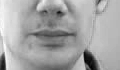

Actual:  bin red by m eight please
Predicted:  bin red by m eight please


In [12]:
actual_texts = []
predicted_texts = training_dataset.ctc_decode(y)

for item in batch[2]:
    actual_texts.append(training_dataset.arr2txt(item.tolist()))

for idx, items in enumerate(zip(batch[0], batch[4])):
    imageio.mimsave(os.path.join("display_data", "gif", f"{idx}.gif"), items[0].permute(1, 2, 3, 0), fps=10)

    clip = moviepy.VideoFileClip(os.path.join("data", "videos", "s1", f"{items[1]}.mpg"))
    clip.write_videofile(os.path.join("display_data", "mp4", f"{idx}.mp4"), fps=30)

    clear_output(wait=True)

    display(Video(os.path.join("display_data", "mp4", f"{idx}.mp4")))
    display(Image(os.path.join("display_data", "gif", f"{idx}.gif")))
    
    print("Actual: ", actual_texts[idx])
    print("Predicted: ", predicted_texts[idx])
    
    user = input("Continue to the next sample?").lower()
    while (user != 'y' and user != 'quit'):
        user = input("Continue to the next sample?").lower()
    
    if user == 'quit':
        break